This notebook serves as an external validation script for validating the models I have pretrained on GBIF images.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from math import sqrt, ceil
import sys, shutil, os, time
from tqdm import tqdm
import re

In [2]:
model_path = "../models/run27/epoch_0_batch_final.pt"
image_directory = "/home/ucloud/testCrops/Set2"
images = os.listdir(image_directory)

def get_image(path, transform=None):
    species = re.search(r"^[^_]+", path).group()
    image = read_image(image_directory + os.sep + path, mode=ImageReadMode.RGB)
    if transform:
        image = transform(image)

    return image, species

In [3]:
# weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
class create_image_preprocessing:
    def __init__(self, weights):
        self.transform = weights.transforms.func(crop_size=256)
        self.isize = self.transform.resize_size[0]
        self.mean = self.transform.mean
        self.std = self.transform.std

    def __call__(self, images):
        """Preprocess images for EfficientNet."""
        images = torchvision.transforms.Resize((self.isize, self.isize), antialias=True)(images)
        return self.transform(images)

image_preprocessing = create_image_preprocessing(weights)

def denormalize(tensor, mean=image_preprocessing.mean, std=image_preprocessing.std):
    """Denormalize a tensor."""
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(torch.float32)
    std = torch.tensor(std).view(1, 3, 1, 1).to(torch.float32)
    return tensor.cpu().to(torch.float32) * std + mean

In [ ]:
## Hyperparameters
skip = 0 # Number of batches to skip (used to resume script from a specific batch)
batch_size = 128 # Batch size for chunked loading of images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype=torch.bfloat16
real_class_index = 0 # The real class index of the species to fine-tune on (6 for the initial model; insectGBIF-1280m6.pt)
inference_size = 640 # The size of the images to run inference on (1280 for the initial model; insectGBIF-1280m6.pt)

In [5]:
# Import YOLOv5 helper functions
from pyremotedata.implicit_mount import *
from pyremotedata.dataloader import *

backend = None

# ERDA data transfer setup
if backend is not None:
    backend.stop()
backend = IOHandler(verbose = False, clean=True)
backend.start()
backend.cd("AMI_GBIF_Pretraining_Data/rebalanced75_without_larvae")
backend.cache_file_index(skip=skip)

# Dataset and dataloader setup
remote_iterator = RemotePathIterator(
        backend,
        batch_size=32,
        max_queued_batches=5,
        n_local_files=5*32*2,
    )

full_dataset = RemotePathDataset(
    remote_iterator,
    prefetch=1*batch_size,
    transform=image_preprocessing,
    # device=device, 
    dtype=dtype, 
    hierarchical=True,
    return_remote_path=False,
    return_local_path=True,
    verbose=False
)

class_counts = class_counting(full_dataset.remote_path_iterator.remote_paths, full_dataset.class_handles)
hierarchy = create_hierarchy(full_dataset.remote_path_iterator.remote_paths, full_dataset.class_handles)
masks = mask_hierarchy(hierarchy, device=device, dtype=dtype)

backend.stop()

Connected to sftp://asgersvenning%40ecos.au.dk:@io.erda.au.dk:2222
Local directory: /tmp/tmp29sbsuf5
IOHandler.start() is unsafe. Use IOHandler.__enter__() instead if possible.
OBS: Remember to call IOHandler.stop() when you are done.
Cleaning up...


In [6]:
# Model definition
model = torchvision.models.efficientnet_b0(weights=None).half().train(False)
num_features = [k for k in [j for j in [i for i in model.children()][0].children()][-1].children()][0].out_channels
num_classes = [len(i) for i in class_counts]

class HierarchicalClassifier(nn.Module):
    def __init__(self, num_features, num_classes, masks, return_embeddings=False):
        super(HierarchicalClassifier, self).__init__()
        self.silu = nn.SiLU()
        self.dropout1 = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(num_features, device=device, dtype=dtype)
        self.linear1 = nn.Linear(num_features, 1024, device=device, dtype=dtype)
        self.bn2 = nn.BatchNorm1d(1024, device=device, dtype=dtype)
        self.dropout2 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(1024, 1024, device=device, dtype=dtype)
        self.bn3 = nn.BatchNorm1d(1024, device=device, dtype=dtype)
        self.dropout3 = nn.Dropout(0.1)
        self.linear3 = nn.Linear(1024, 512, device=device, dtype=dtype)
        self.bn4 = nn.BatchNorm1d(512, device=device, dtype=dtype)
        self.dropout4 = nn.Dropout(0.1)
        # self.linear_logits = [nn.Linear(512, ncls, device=device, dtype=dtype) for ncls in num_classes]
        self.leaf_logits = nn.Linear(512, num_classes[0], device=device, dtype=dtype)
        self.bn5 = nn.BatchNorm1d(num_classes[0], device=device, dtype=dtype)
        self.masks = masks.copy()

        self.return_embeddings = return_embeddings
        
    def forward(self, x):
        if self.return_embeddings:
            embeddings = x.clone()
        x = self.dropout1(x)
        x = self.bn1(x)
        x = self.linear1(x)
        x = self.bn2(x)
        x = self.silu(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        x = self.bn3(x)
        x = self.silu(x)
        x = self.dropout3(x)
        x = self.linear3(x)
        x = self.bn4(x)
        x = self.silu(x)
        x = self.dropout4(x)
        x = self.leaf_logits(x)
        x = self.silu(x)
        y = self.bn5(x)
        y0 = F.log_softmax(y, dim = 1)
        y1 = F.log_softmax(torch.logsumexp(y0.unsqueeze(2) + self.masks[0].T, dim = 1), dim = 1)
        y2 = F.log_softmax(torch.logsumexp(y1.unsqueeze(2) + self.masks[1].T, dim = 1), dim = 1)
        if self.return_embeddings:
            return [y0, y1, y2], embeddings
        else:
            return [y0, y1, y2]


model.to(device=device, dtype=dtype)
model.classifier = HierarchicalClassifier(num_features, num_classes, masks, return_embeddings=True)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
pass

/home/ucloud/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


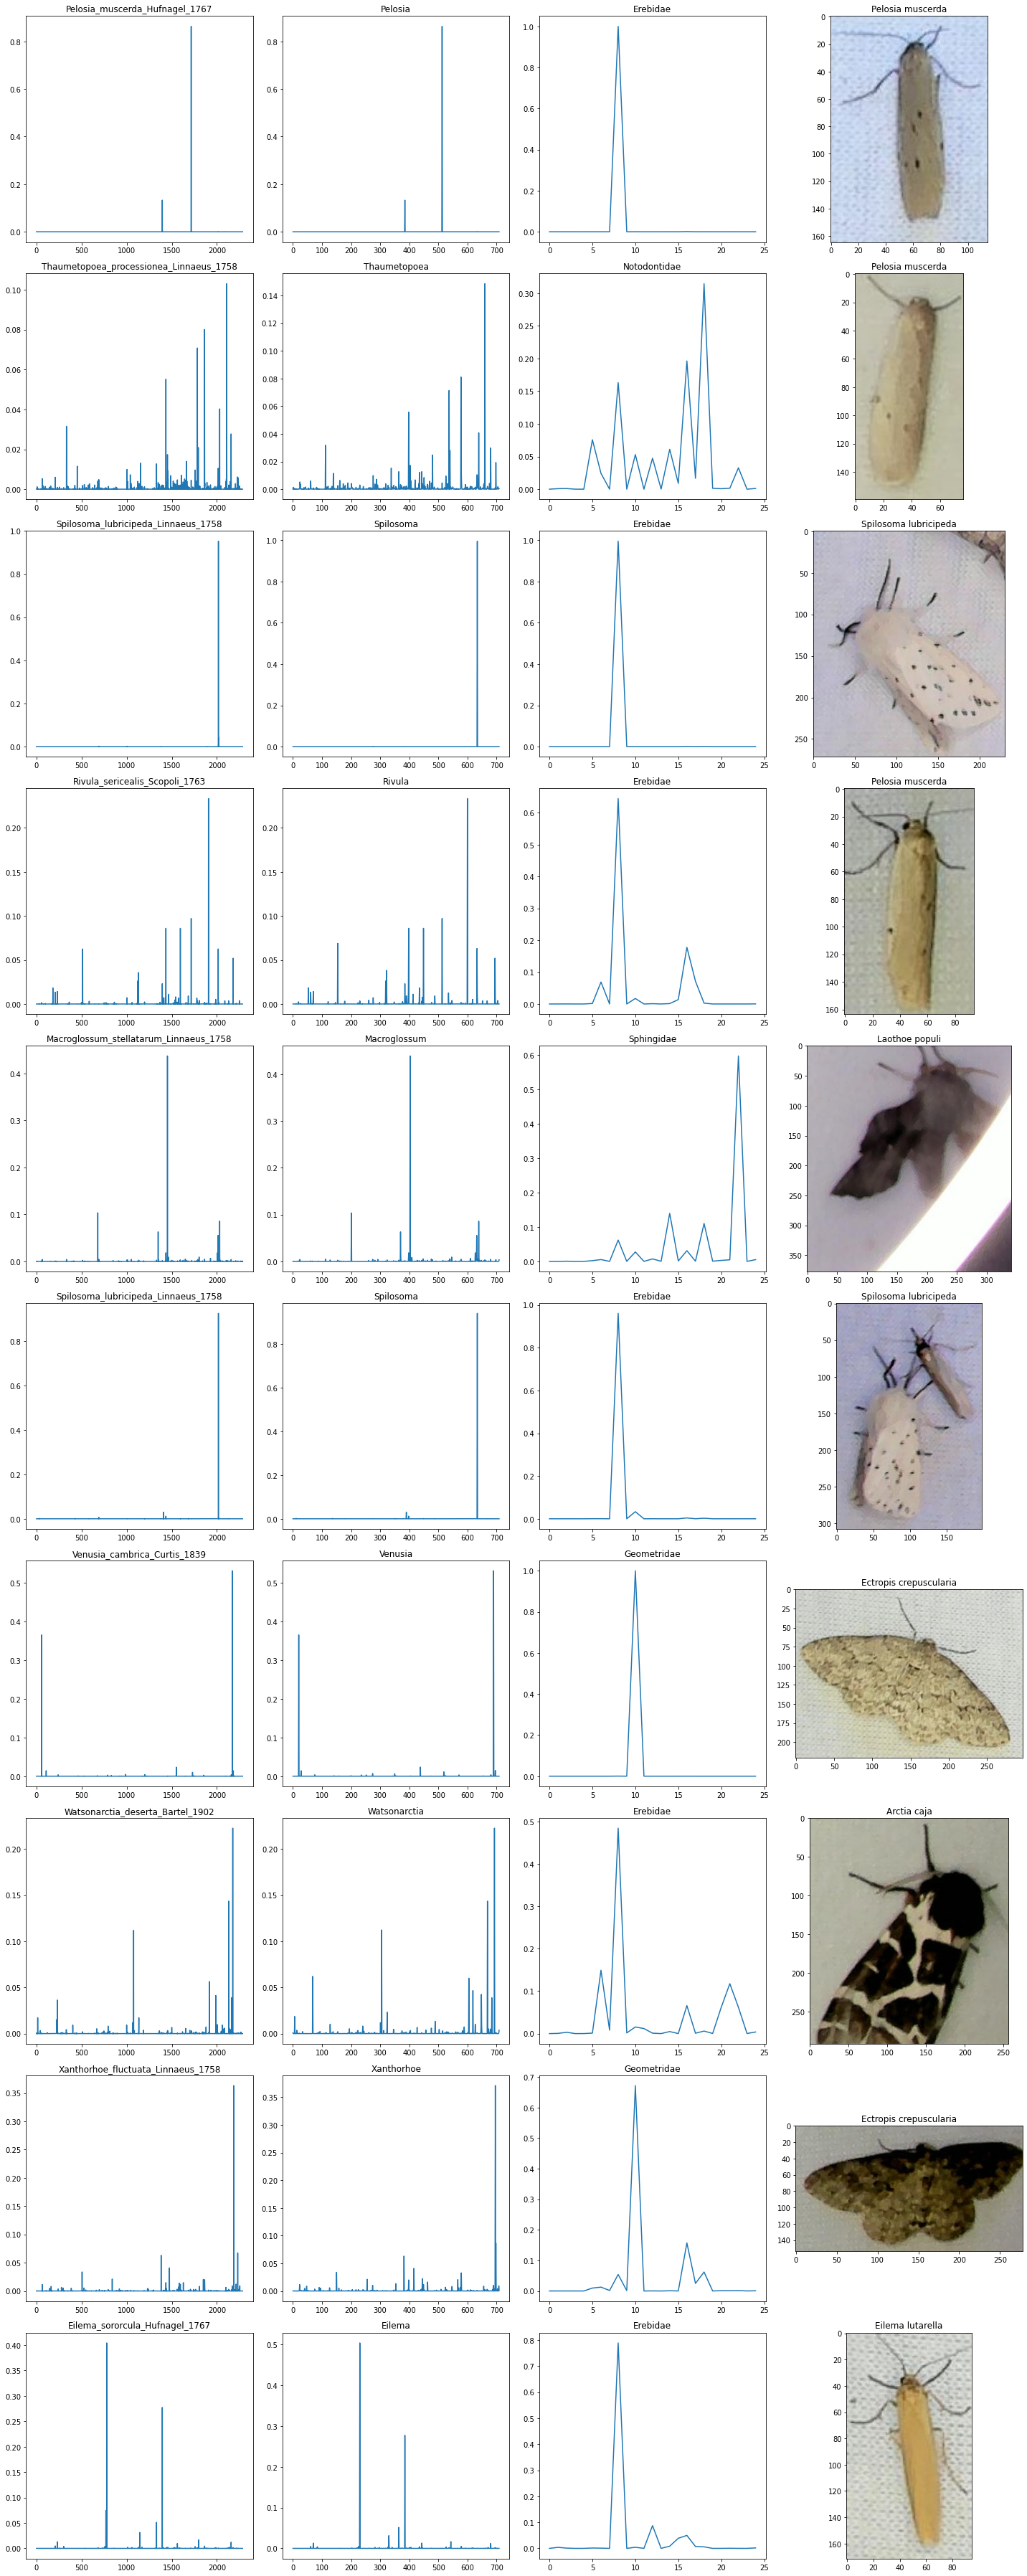

In [7]:
ninf = 10

# Inference
with torch.no_grad():
    inputs = []
    species = []
    for i in range(32):
        timg, tsp = get_image(images[i], image_preprocessing)
        
        inputs.append(timg)
        species.append(tsp)

    inputs = torch.stack(inputs)
    test = model(inputs.to(device=device, dtype=dtype))[0]

predictions = [i.argmax(1) for i in test]
plabels = [[d[j.item()] for j in i] for i, d in zip(predictions, full_dataset.idx_to_class) ]

fig, axs = plt.subplots(ninf,4, figsize=(20, 5 * ninf))

for sample in range(ninf):
    for level in range(4):
        if level < 3:
            ys = test[level][sample].softmax(0).float().cpu().numpy()
            xs = np.arange(len(ys))
            axs[sample, level].plot(xs, ys)
            axs[sample, level].set_title(plabels[level][sample])
        else:
            axs[sample, level].imshow(read_image(image_directory + os.sep + images[sample], mode=ImageReadMode.RGB).permute(1, 2, 0).numpy() / 255)
            axs[sample, level].set_title(species[sample])

plt.tight_layout()
plt.show()

In [8]:
ninf = len(images)

batches = []

for i, img in enumerate(images):
    batch_index = i // 32
    if i % 32 == 0:
        batches.append([])
    batches[batch_index].append(img)

# Inference
with torch.no_grad():
    predictions = []
    species = []
    embeddings = []
    for batch_index, batch in enumerate(batches):
        inputs = []
        for path in batch:
            timg, tsp = get_image(path, image_preprocessing)
            species += [tsp]
            inputs += [timg]
        inputs = torch.stack(inputs).to(device=device, dtype=dtype)
        pred, emb = model(inputs)
        embeddings += [emb]
        if not predictions:
            predictions = pred
        else:
            predictions = [torch.cat((i, j)) for i, j in zip(predictions, pred)]

plabels = [[d[j.item()] for j in i.argmax(1)] for i, d in zip(predictions, full_dataset.idx_to_class)]

embeddings = torch.concat(embeddings).float().cpu().numpy()

In [9]:
genera_in_test = sorted(list(set([re.search(r'^\S+', i).group() for i in images])))
species_in_test = sorted(list(set([re.search(r'^\S+\s[^_ ]+', i).group() for i in images])))

dataset_species = [re.sub("_", " ", re.search(r'^[^_]+_[^_]+', i).group()) for i in full_dataset.classes[0]]

genera_is_possible = {species : species in full_dataset.classes[1] for species in genera_in_test}
species_is_possible = {species : species in dataset_species for species in species_in_test}

In [10]:
print(f'Total = {len(species)}')

sp_correct = sum([i == re.sub("_", " ", re.search(r"^[^_]+_[^_]+", j).group()) for i, j in zip(species, plabels[0])])
sp_possible = sum([species_is_possible[i] for i in species])
ge_correct = sum([re.search(r'^\S+', i).group() == j for i, j in zip(species, plabels[1])])
ge_possible = sum([genera_is_possible[re.search(r'^\S+', i).group()] for i in species])

print(f'Species = {sp_correct / len(species) * 100:.2f}% (max = {sp_possible / len(species) * 100:.2f}%)')
print(f'Genus = {ge_correct / len(species) * 100:.2f}% (max = {ge_possible / len(species) * 100:.2f}%)')

Total = 528
Species = 37.50% (max = 90.53%)
Genus = 49.81% (max = 98.48%)


In [11]:
confmat_dict = {}

for true, predicted in zip(species, plabels[0]):
    predicted = re.search(r'^[^_]+_[^_]+', predicted).group()
    predicted = re.sub("_", " ", predicted)

    if true not in confmat_dict:
        confmat_dict[true] = {}
    if predicted not in confmat_dict:
        confmat_dict[predicted] = {}
    if predicted not in confmat_dict[true]:
        confmat_dict[true][predicted] = 0
    if true not in confmat_dict[predicted]:
        confmat_dict[predicted][true] = 0
    confmat_dict[true][predicted] += 1


genus_confmat_dict = {}
for true, predicted in zip(species, plabels[0]):
    predicted = re.search(r'^[^_]+_[^_]+', predicted).group()
    predicted = re.sub("_", " ", predicted)

    predicted = re.search(r'^\S+', predicted).group()
    true = re.search(r'^\S+', true).group()

    if true not in genera_is_possible or not genera_is_possible[true]:
        continue

    if true not in genus_confmat_dict:
        genus_confmat_dict[true] = {}
    # if predicted not in genus_confmat_dict:
    #     genus_confmat_dict[predicted] = {}
    if predicted not in genus_confmat_dict[true]:
        genus_confmat_dict[true][predicted] = 0
    # if true not in genus_confmat_dict[predicted]:
    #     genus_confmat_dict[predicted][true] = 0
    genus_confmat_dict[true][predicted] += 1

<ipython-input-12-e3f5bef4bbba>:19: RuntimeWarning: invalid value encountered in divide
  confmat = confmat / np.sum(confmat, axis=1, keepdims=True) * 100


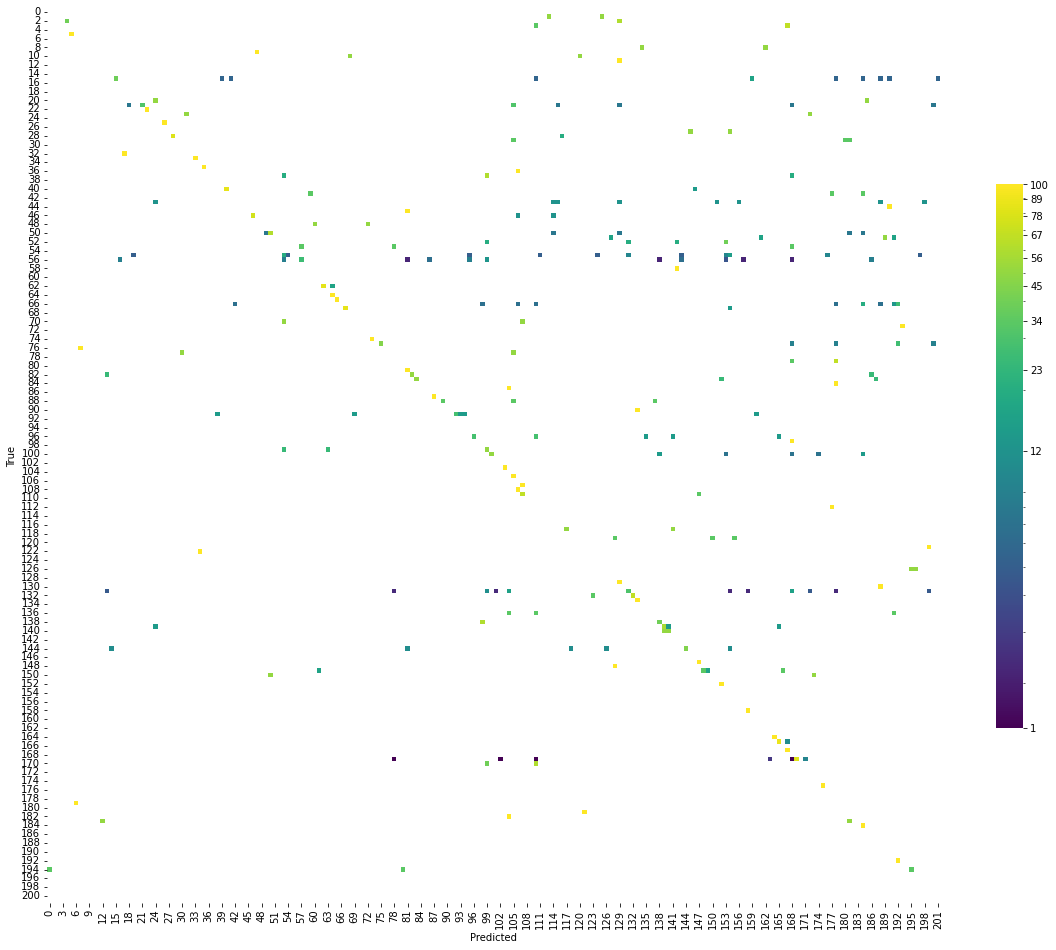

In [12]:
import matplotlib as mpl
import seaborn as sns

# Sort confusion matrix by species name
confmat_dict_sorted = {}
for key in sorted(confmat_dict.keys()):
    confmat_dict_sorted[key] = {}
    for key2 in sorted(confmat_dict[key].keys()):
        confmat_dict_sorted[key][key2] = confmat_dict[key][key2]

# Convert confusion matrix to numpy array
confmat = np.zeros((len(confmat_dict_sorted.keys()), len(confmat_dict_sorted.keys())))
confmat_sp_to_idx = {key : i for i, key in enumerate(confmat_dict_sorted.keys())}

for true in confmat_dict_sorted.keys():
    for predicted in confmat_dict_sorted[true].keys():
        confmat[confmat_sp_to_idx[true], confmat_sp_to_idx[predicted]] = confmat_dict_sorted[true][predicted]

confmat = confmat / np.sum(confmat, axis=1, keepdims=True) * 100
confmat[np.isnan(confmat)] = 0
confmat[confmat == 0] = -np.inf

plt.figure(figsize=(20, 20))
sns.heatmap(confmat, cmap='viridis', annot=False, norm=mpl.colors.LogNorm(), cbar_kws={'shrink': 0.5, 'ticks': np.linspace(confmat[confmat > 0].min(), confmat.max(), 10), 'format': '%.0f'})
# Axis title
plt.xlabel('Predicted')
plt.ylabel('True')

# Aspect ratio = 1
plt.gca().set_aspect('equal', adjustable='box')

<ipython-input-13-90ed5cf7d412>:17: RuntimeWarning: invalid value encountered in divide
  confmat = confmat / np.sum(confmat, axis=1, keepdims=True)


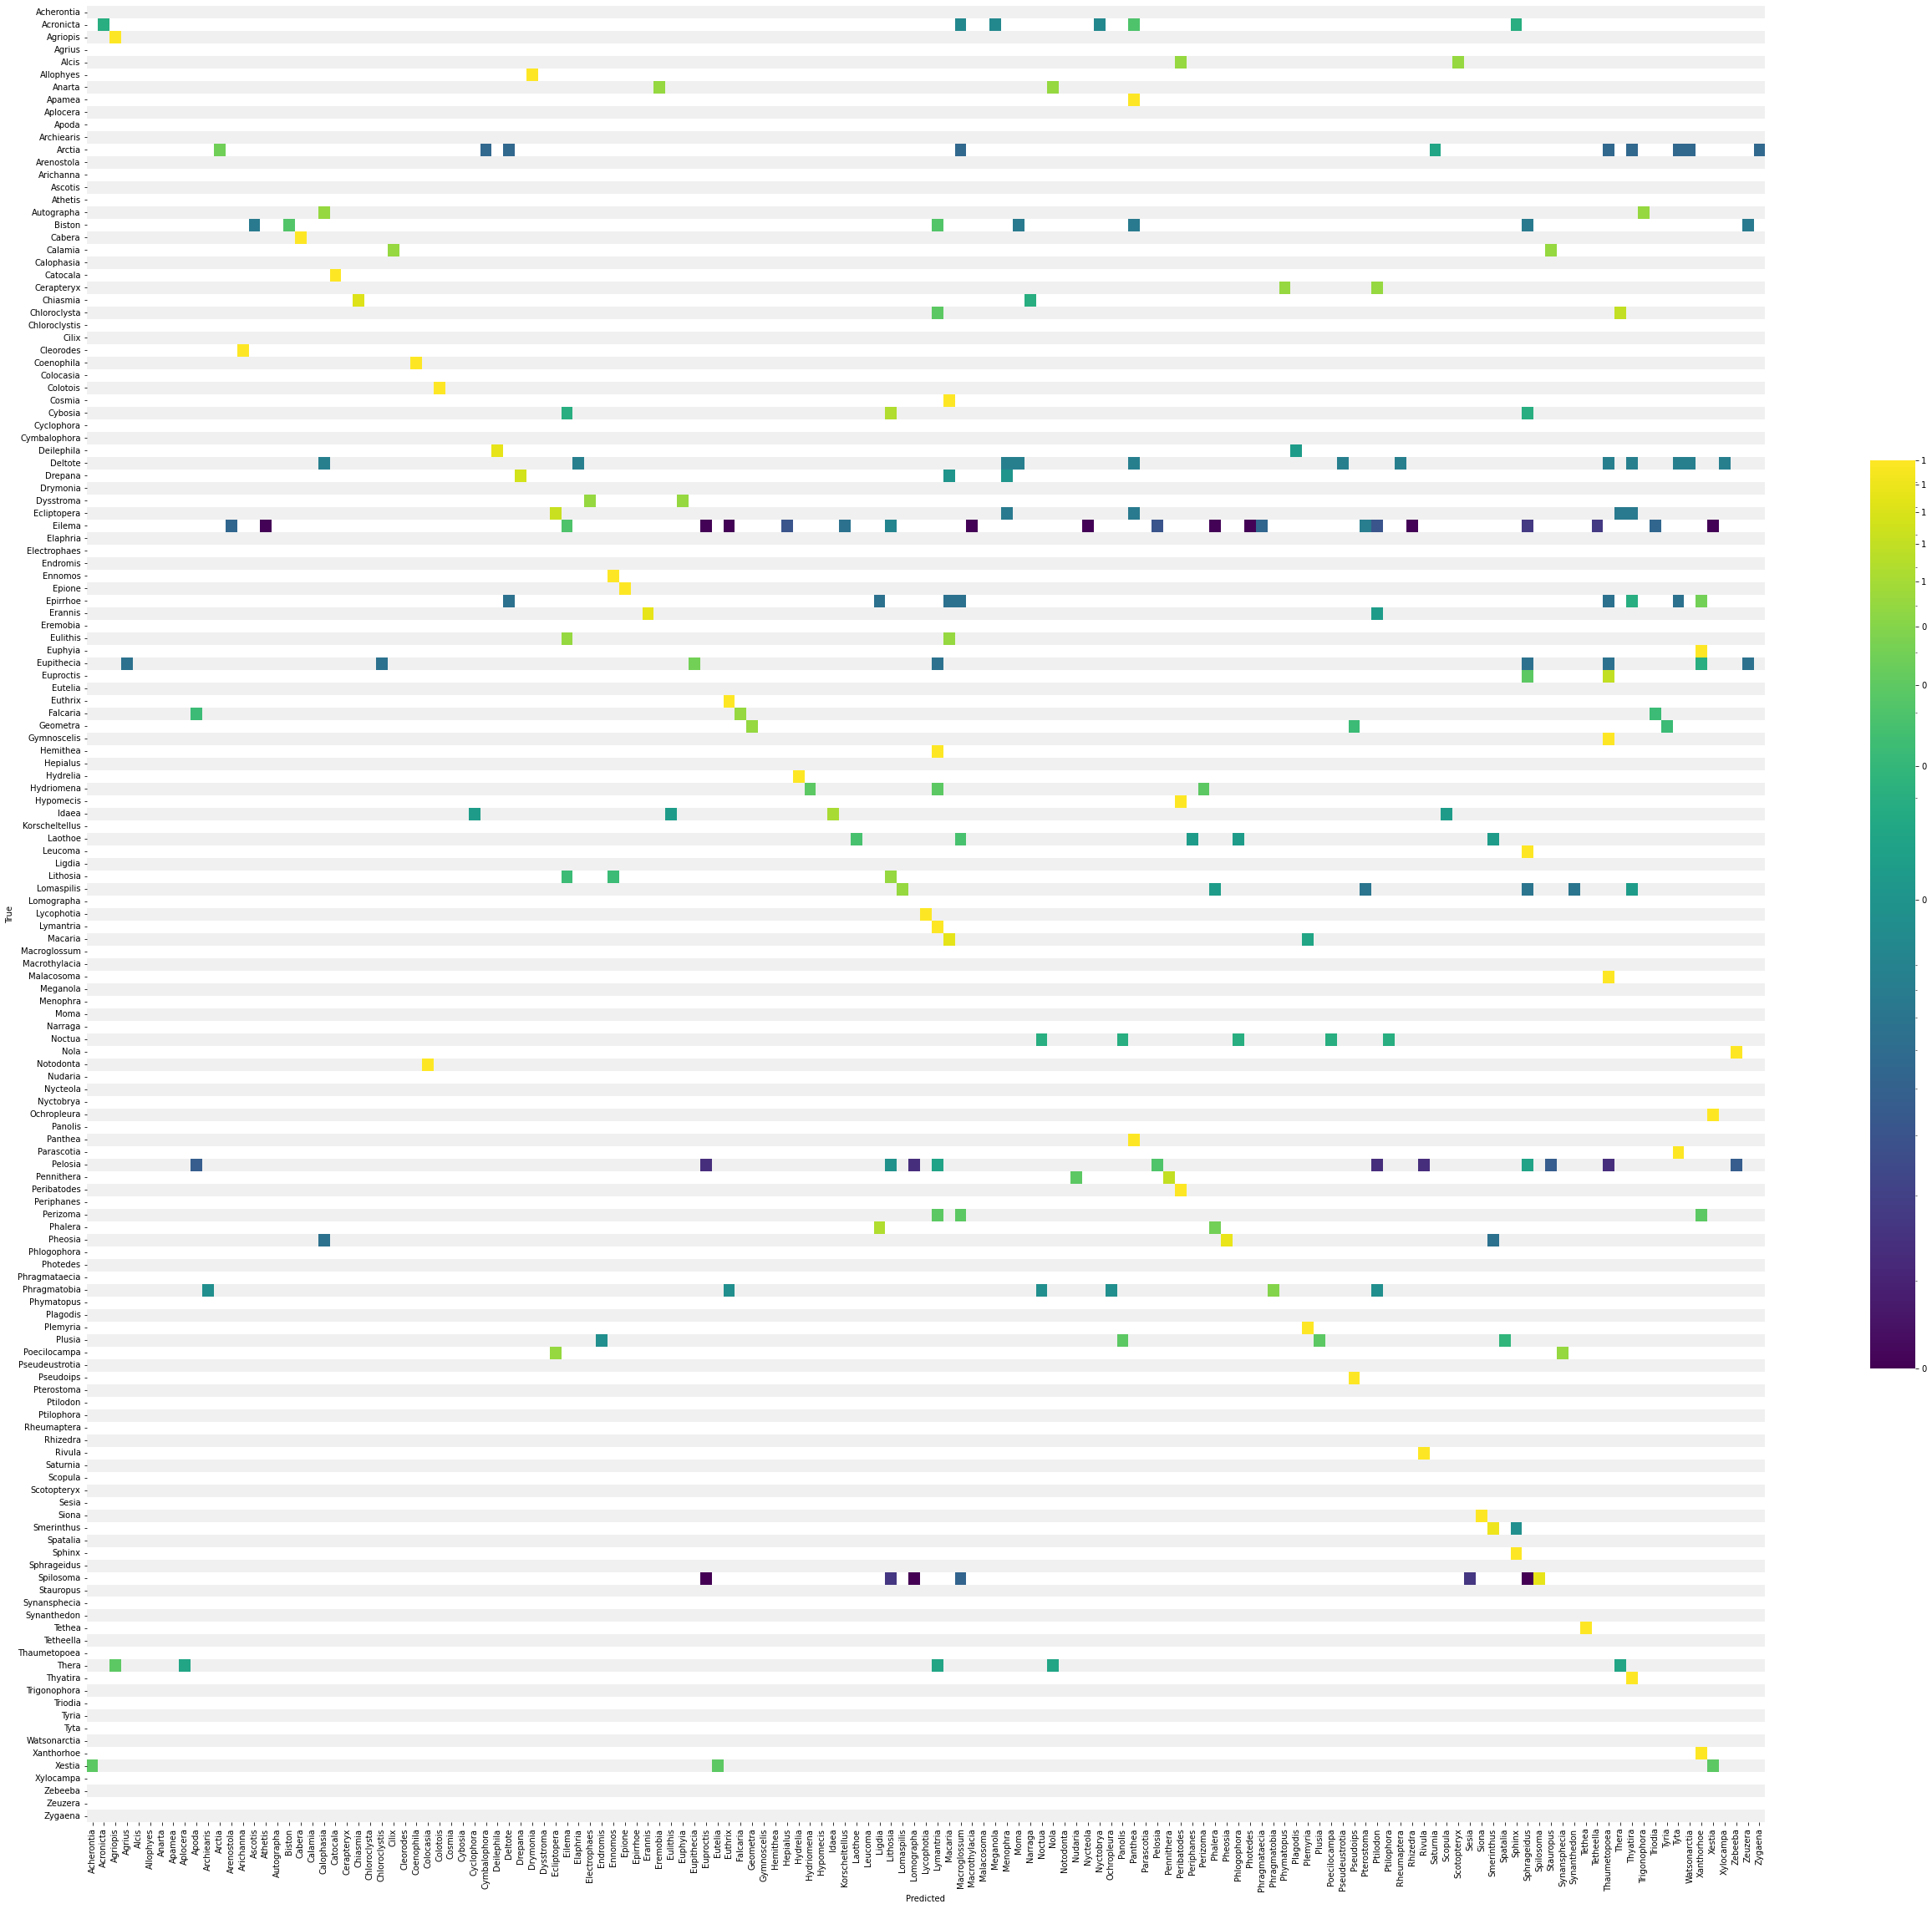

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

possible_genera = full_dataset.classes[1]

# Convert confusion matrix to numpy array
confmat_sp_to_idx = {key: i for i, key in enumerate(sorted(list(set(list(genus_confmat_dict.keys()) + [k for i in genus_confmat_dict.values() for k in i.keys()]))))}
nsp = len(confmat_sp_to_idx.keys())
confmat = np.zeros((nsp, nsp))

for true in genus_confmat_dict.keys():
    for predicted in genus_confmat_dict[true].keys():
        confmat[confmat_sp_to_idx[true], confmat_sp_to_idx[predicted]] = genus_confmat_dict[true][predicted]

# Normalize confusion matrix
confmat = confmat / np.sum(confmat, axis=1, keepdims=True)
confmat[np.isnan(confmat)] = 0

# Create striped background and red impossible true prediction cells
background = np.zeros_like(confmat)
background[::2, :] = 1
impossible_true_cells = np.zeros_like(confmat)

for genus in confmat_sp_to_idx.keys():
    if genus not in possible_genera:
        impossible_true_cells[confmat_sp_to_idx[genus], confmat_sp_to_idx[genus]] = 1

# Plotting
plt.figure(figsize=(45, 40))
sns.heatmap(background, cmap=mpl.colors.ListedColormap(["#ffffff", "#f0f0f0"]), cbar=False)
sns.heatmap(impossible_true_cells, cmap=mpl.colors.ListedColormap(["#00000000", "#cc0033"]), cbar=False)
sns.heatmap(confmat, cmap='viridis', norm=mpl.colors.LogNorm(vmin=confmat[confmat != 0].min(), vmax=confmat.max()), annot=False, xticklabels=confmat_sp_to_idx.keys(), yticklabels=confmat_sp_to_idx.keys(), alpha=1, cbar_kws={'shrink': 0.5, 'ticks': np.linspace(confmat[confmat > 0].min(), confmat.max(), 10), 'format': '%.0f'})

plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.show()


## Embeddings

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


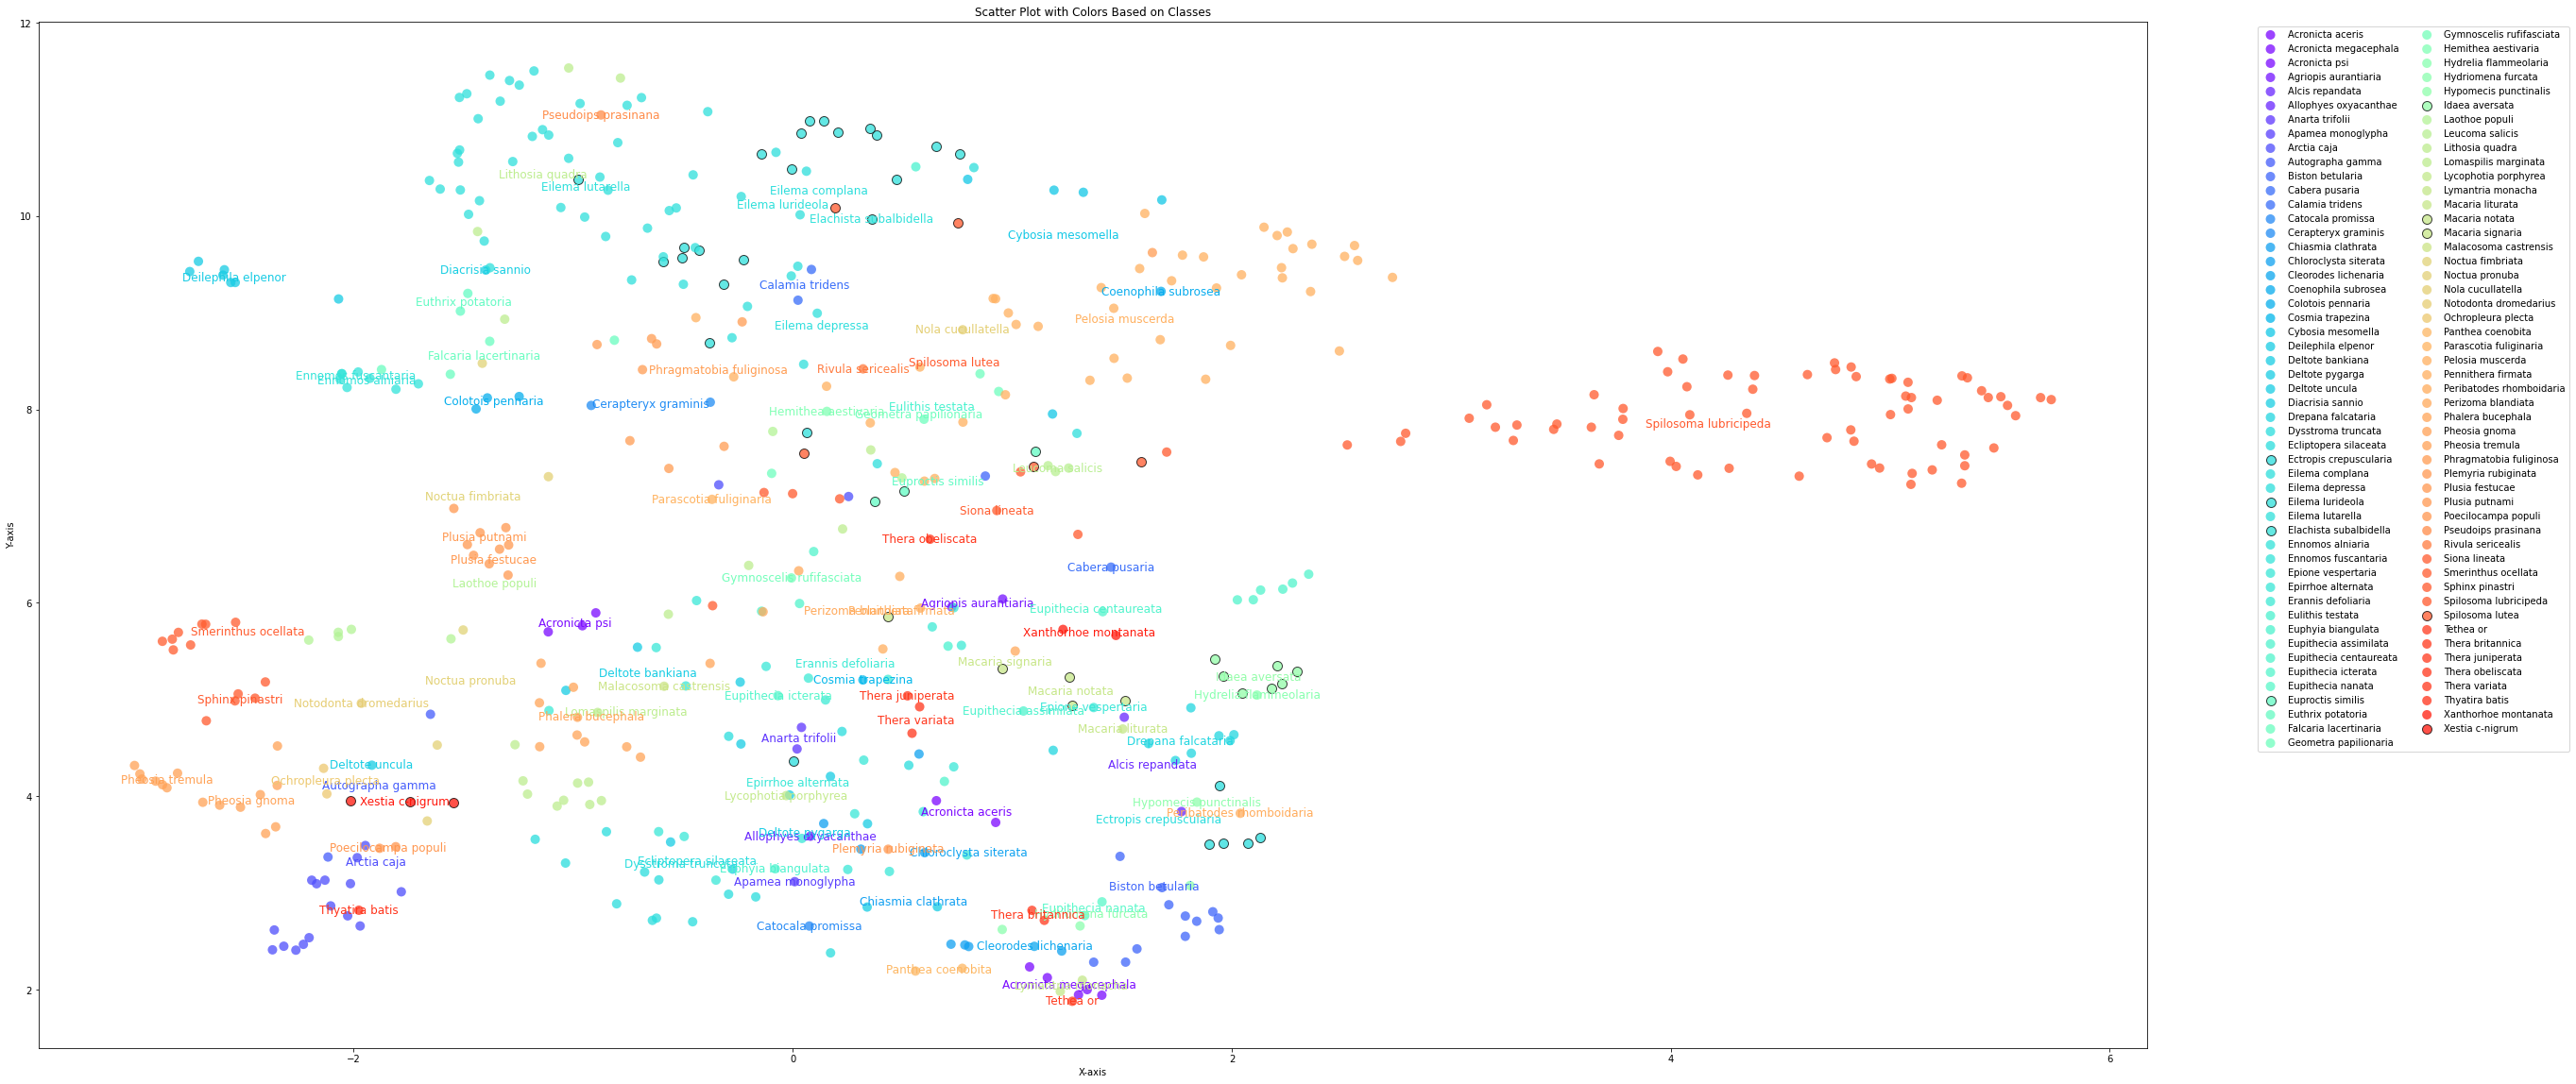

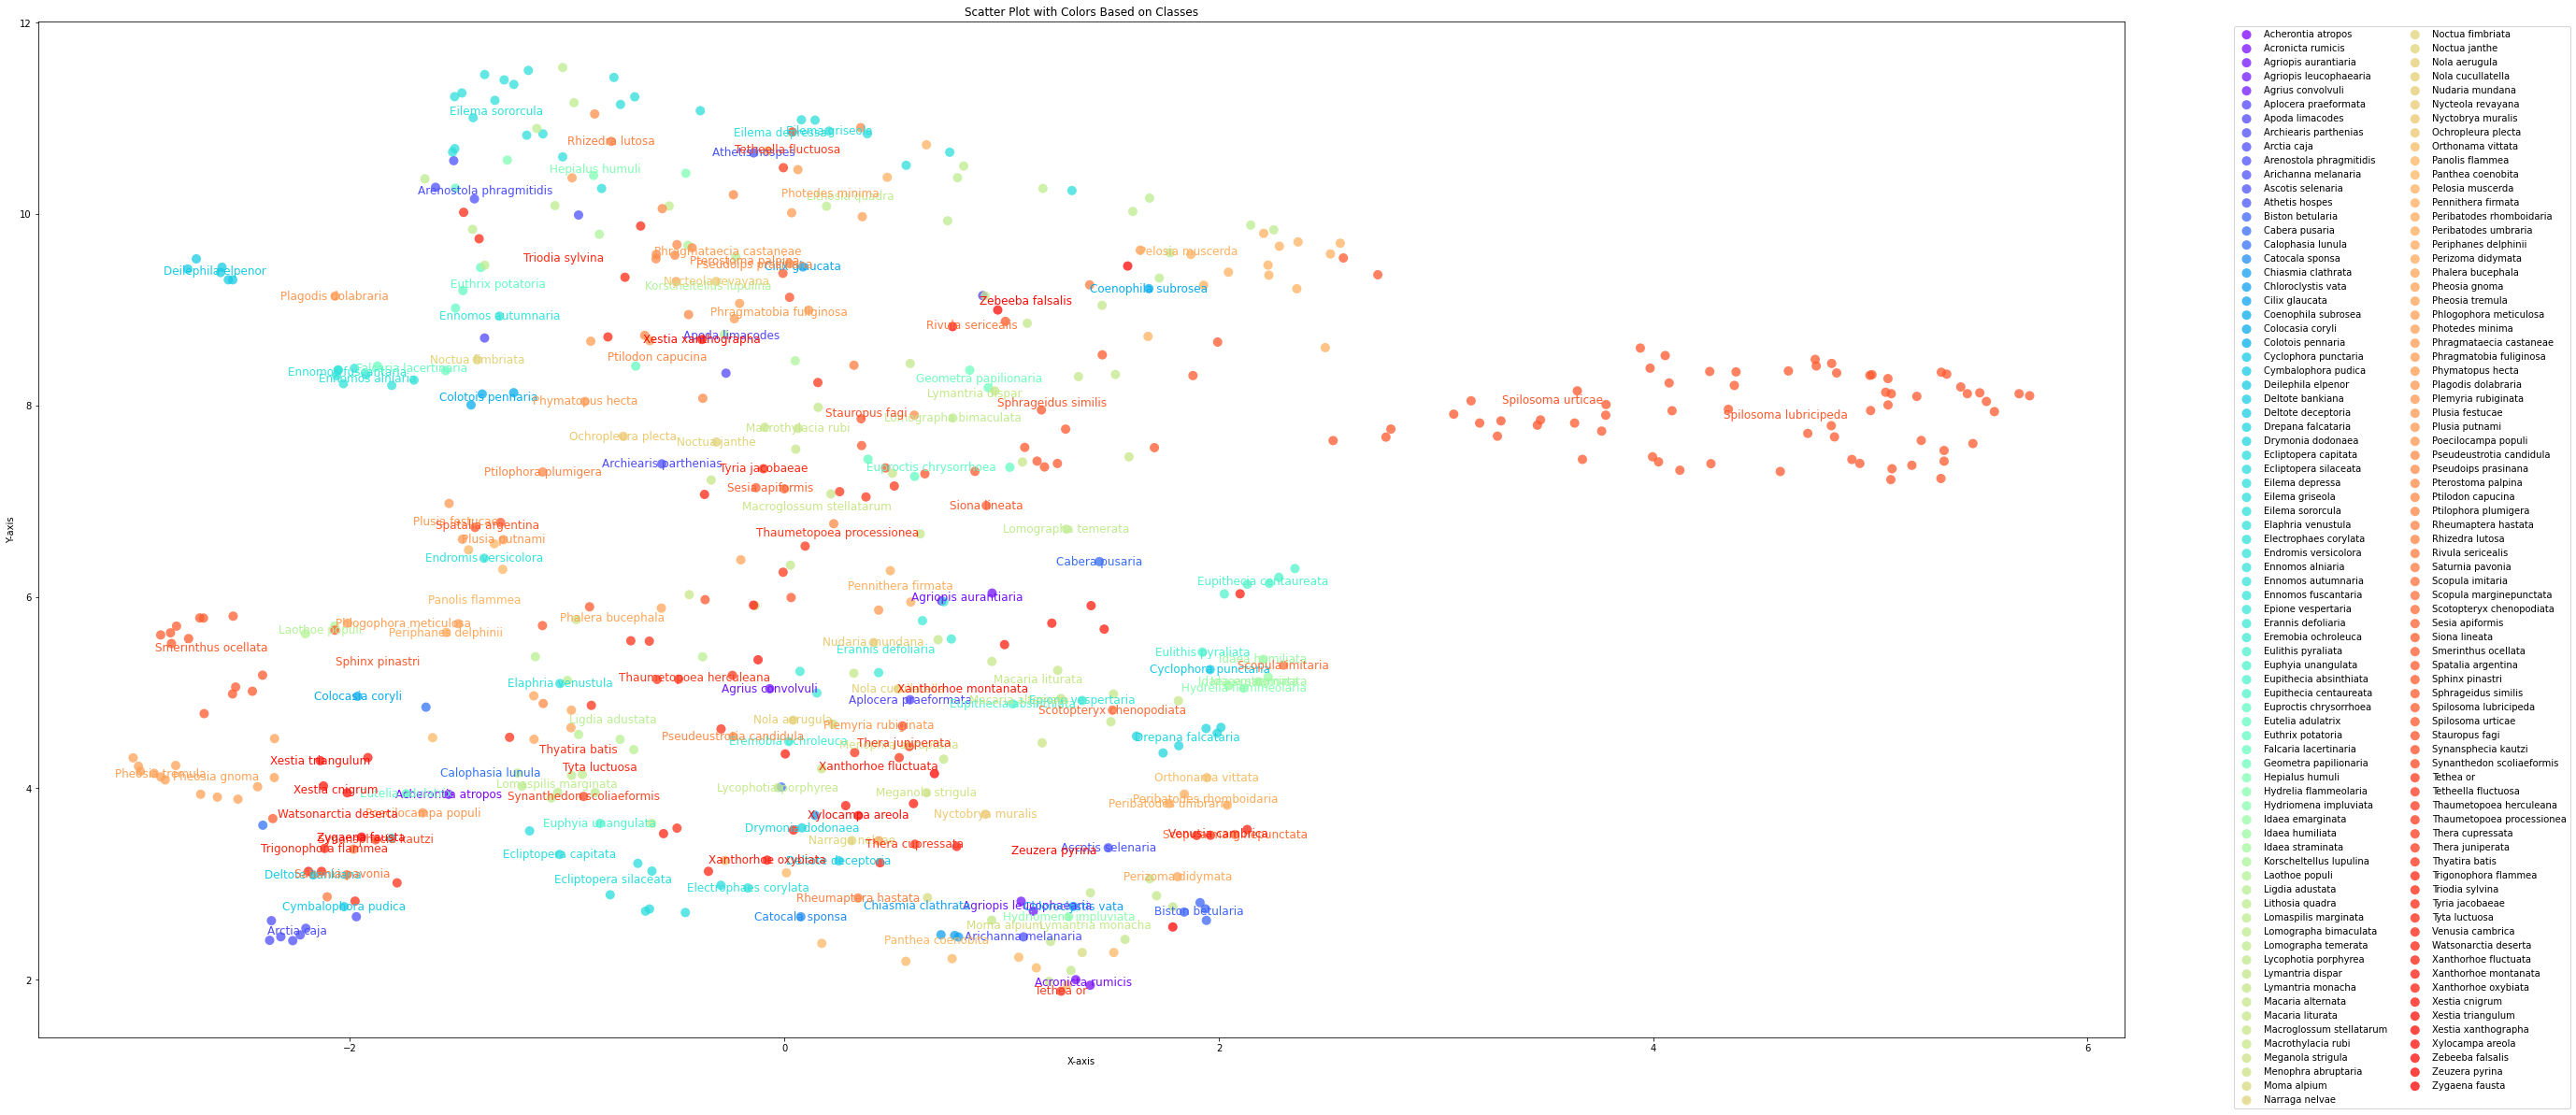

In [14]:
import umap

# UMAP embedding
emb_umap = umap.UMAP(n_neighbors=25, min_dist=0.3, metric='euclidean', random_state=42).fit_transform(embeddings)

# Create a scatter plot with colors based on classes
unique_classes = sorted(set(species + [re.sub("_", " ", re.search(r'^[^_]+_[^_]+', i).group()) for i in full_dataset.classes[0]]))
possible_classes = [re.sub("_", " ", re.search(r'^[^_]+_[^_]+', i).group()) for i in full_dataset.classes[0]]
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))

plt.figure(figsize=(40, 20))

for i, cls in enumerate(unique_classes):
    tcls = [species[j] == cls for j in range(len(emb_umap))]
    if not any(tcls):
        continue
    ps = emb_umap[tcls]
    plt.scatter(ps[:,0], ps[:,1], color=colors[i], label=cls, edgecolors='none' if cls in possible_classes else 'black', alpha=0.75, s=100)
    plt.text(ps[:,0].mean(), ps[:,1].mean(), cls, fontsize=12, color=colors[i], ha='center', va='center')

plt.legend(fontsize='medium', ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Colors Based on Classes')
plt.show()

plt.figure(figsize=(40, 20))

for i, cls in enumerate(unique_classes):
    tcls = [re.sub("_", " ", re.search(r'^[^_]+_[^_]+', plabels[0][j]).group()) == cls for j in range(len(emb_umap))]
    if not any(tcls):
        continue
    ps = emb_umap[tcls]
    plt.scatter(ps[:,0], ps[:,1], color=colors[i], label=cls, edgecolors='none' if cls in possible_classes else 'black', alpha=0.75, s=100)
    plt.text(ps[:,0].mean(), ps[:,1].mean(), cls, fontsize=12, color=colors[i], ha='center', va='center')

plt.legend(fontsize='medium', ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Colors Based on Classes')
plt.show()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


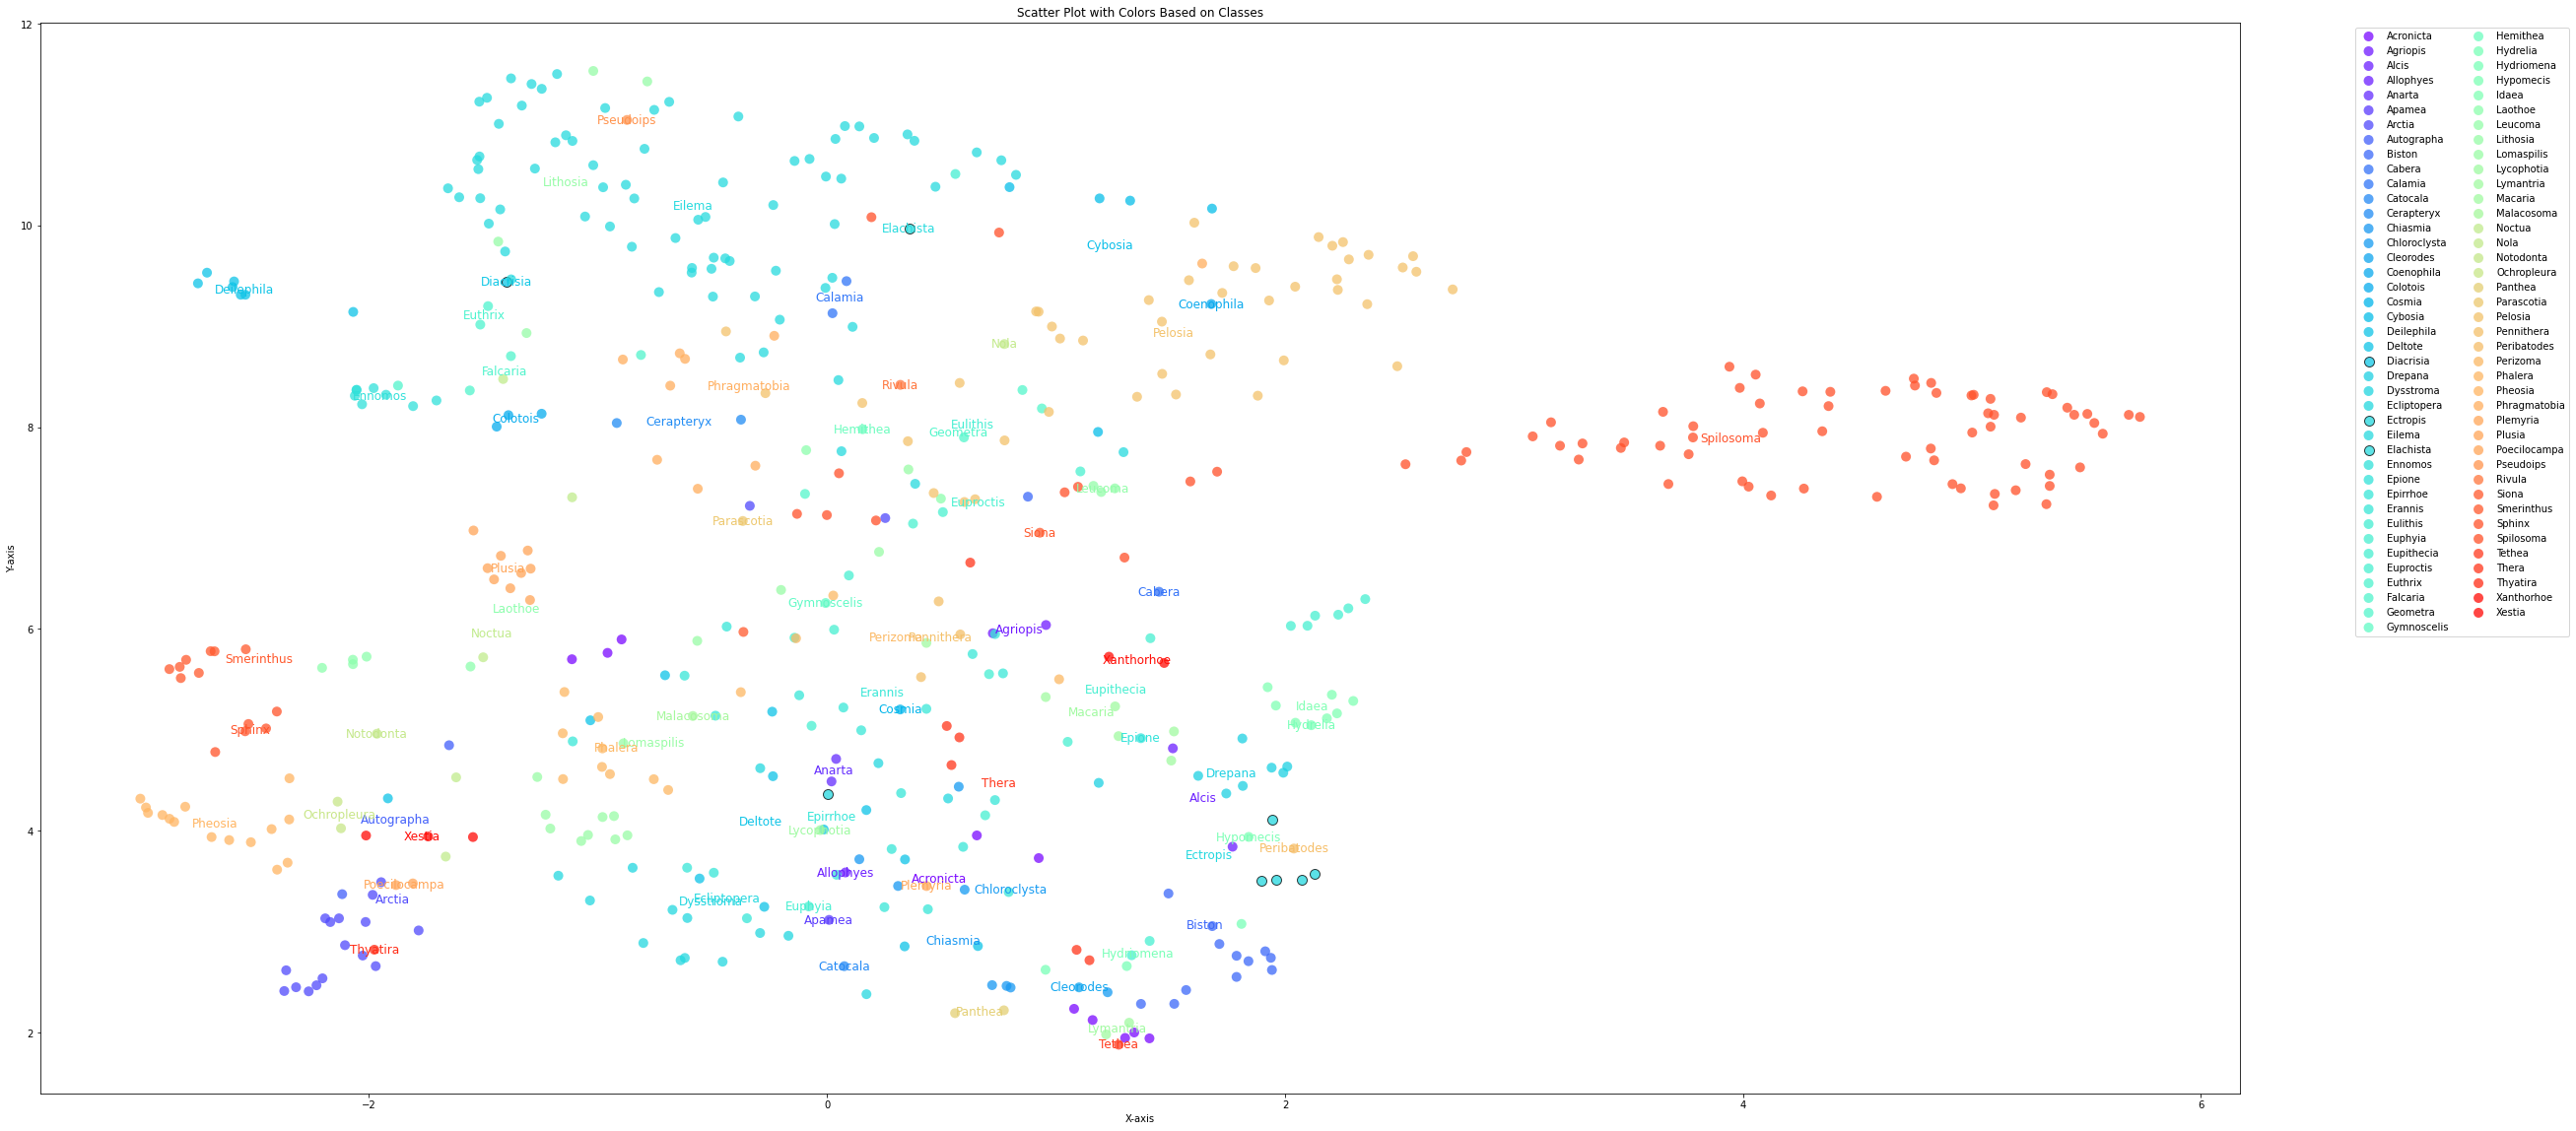

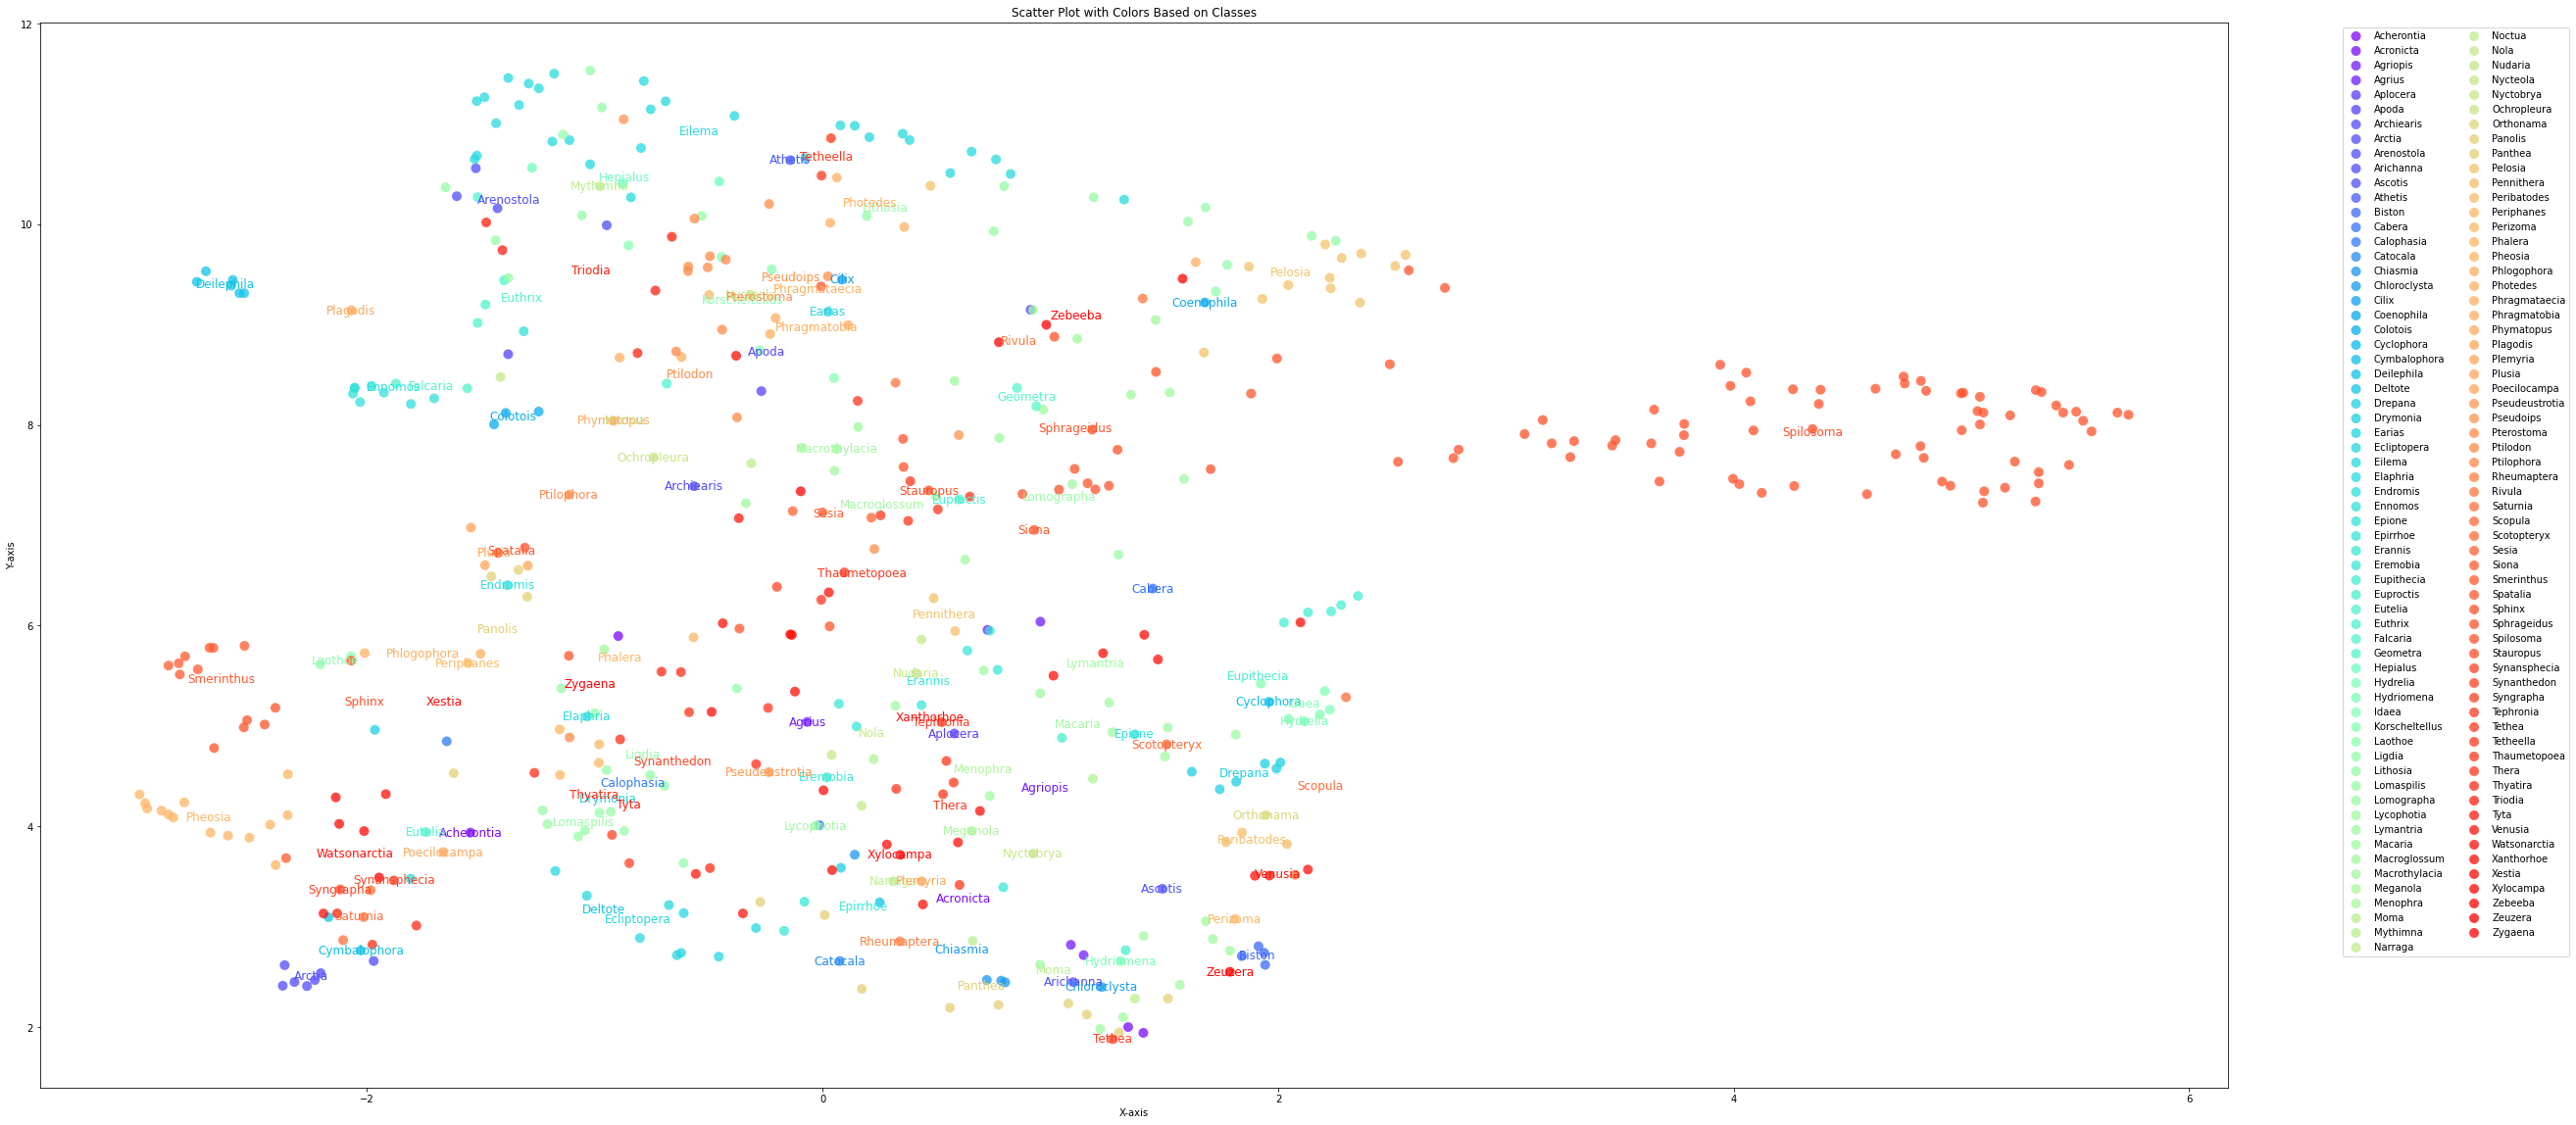

In [15]:
import umap

# UMAP embedding
emb_umap = umap.UMAP(n_neighbors=25, min_dist=0.3, metric='euclidean', random_state=42).fit_transform(embeddings)

# Create a scatter plot with colors based on classes
unique_classes = sorted(set([re.search("^[^_\s]+", i).group() for i in species] + full_dataset.classes[1]))
possible_classes = full_dataset.classes[1]
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))

plt.figure(figsize=(40, 20))

for i, cls in enumerate(unique_classes):
    tcls = [re.search("^[^_\s]+", species[j]).group() == cls for j in range(len(emb_umap))]
    if not any(tcls):
        continue
    ps = emb_umap[tcls]
    plt.scatter(ps[:,0], ps[:,1], color=colors[i], label=cls, edgecolors='none' if cls in possible_classes else 'black', alpha=0.75, s=100)
    plt.text(ps[:,0].mean(), ps[:,1].mean(), cls, fontsize=12, color=colors[i], ha='center', va='center')

plt.legend(fontsize='medium', ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Colors Based on Classes')
plt.show()

plt.figure(figsize=(40, 20))

for i, cls in enumerate(unique_classes):
    tcls = [plabels[1][j] == cls for j in range(len(emb_umap))]
    if not any(tcls):
        continue
    ps = emb_umap[tcls]
    plt.scatter(ps[:,0], ps[:,1], color=colors[i], label=cls, edgecolors='none' if cls in possible_classes else 'black', alpha=0.75, s=100)
    plt.text(ps[:,0].mean(), ps[:,1].mean(), cls, fontsize=12, color=colors[i], ha='center', va='center')

plt.legend(fontsize='medium', ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Colors Based on Classes')
plt.show()

In [16]:
def genus_to_family(genus):
    if isinstance(genus, str):
        try:
            genus_idx = full_dataset.class_to_idx[1][genus]
        except:
            return None
    elif isinstance(genus, int):
        genus_idx = genus
    else:
        raise TypeError("genus must be either a string or an integer")
    family_idx = torch.where(masks[1][:,genus_idx] >= 0)[0].item()
    family = full_dataset.idx_to_class[2][family_idx]
    return family

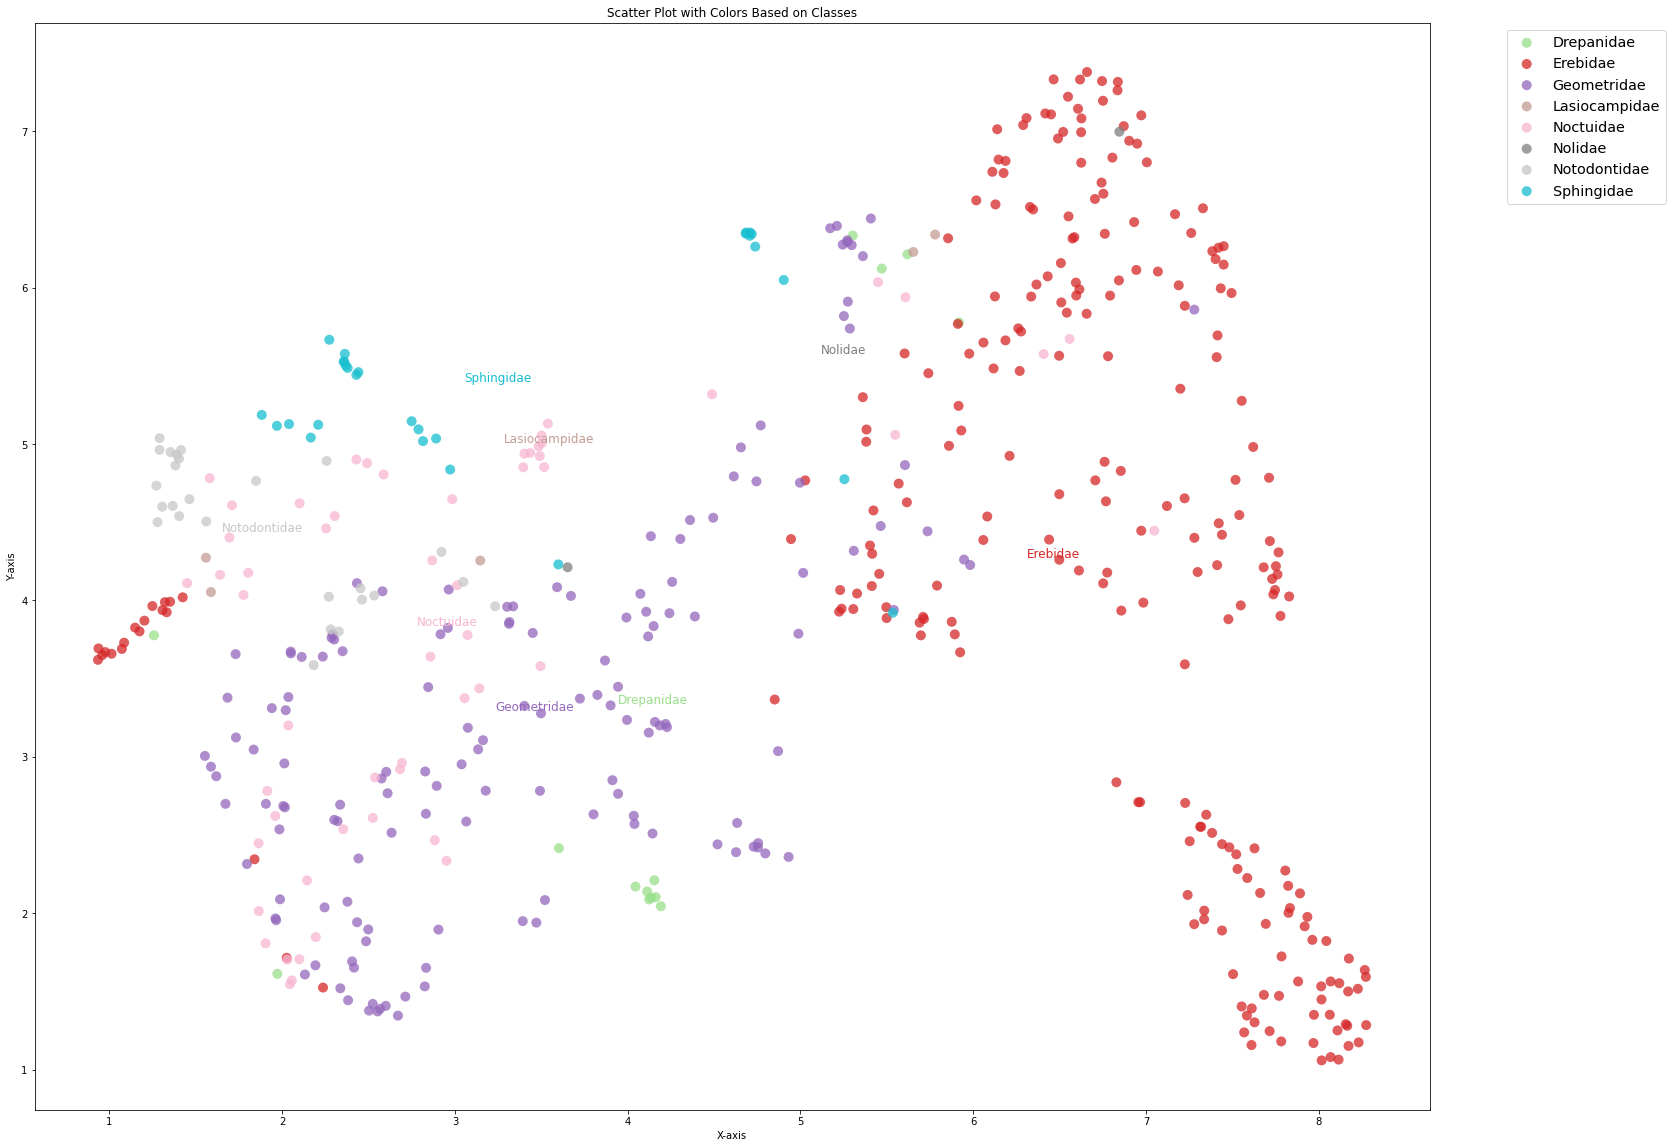

In [17]:
import umap

# UMAP embedding
emb_umap = umap.UMAP(n_neighbors=50, min_dist=0.1, metric='manhattan').fit_transform(embeddings)

# Create a scatter plot with colors based on classes
unique_classes = sorted(set(full_dataset.classes[2]))
possible_classes = full_dataset.classes[2]
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))

plt.figure(figsize=(25, 20))

for i, cls in enumerate(unique_classes):
    tcls = [genus_to_family(re.search("^[^_\s]+", species[j]).group()) == cls for j in range(len(emb_umap))]
    if not any(tcls):
        continue
    ps = emb_umap[tcls]
    plt.scatter(ps[:,0], ps[:,1], color=colors[i], label=cls, edgecolors='none' if cls in possible_classes else 'black', alpha=0.75, s=100)
    plt.text(ps[:,0].mean(), ps[:,1].mean(), cls, fontsize=12, color=colors[i], ha='center', va='center')

plt.legend(fontsize='x-large', ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Colors Based on Classes')
plt.show()